# Building a neural receiver, training and testing it 

### WORK IN PROGRESS

In [1]:
from config import *
import torch
#from models_local import ResidualBlock
#from models_local import Model

from OFDM_SDR_Functions_torch import *
import numpy as np
import random


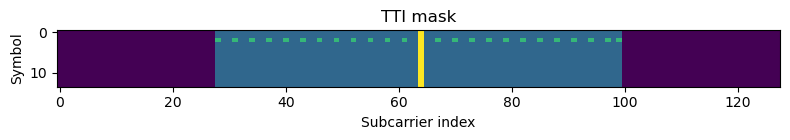

In [2]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=True)
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power)

In [3]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols = create_PDSCH_data(TTI_mask_RE, Qm, mapping_table_Qm, power=PDSCH_power)
    Modulated_TTI = RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotTTI=False)
    TD_TTI_IQ = FFT(Modulated_TTI)
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP)
    #zeros = torch.zeros(0, dtype=TX_Samples.dtype)
    #TX_Samples = torch.cat((zeros, TX_Samples), dim=0)
    return pdsch_bits, TX_Samples

In [20]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self):
        self.pdsch_iq = []
        self.pilot_iq = []
        self.labels = []
        
    def __len__(self):
        return len(self.pdsch_iq)
    
    def __getitem__(self, index):
        x1 = self.pdsch_iq[index]
        x2 = self.pilot_iq[index]
        y = self.labels[index]
        return x1, x2, y
    
    def add_item(self, new_pdsch_iq, new_pilot_iq, new_label):
        self.pdsch_iq.append(new_pdsch_iq)
        self.pilot_iq.append(new_pilot_iq)
        self.labels.append(new_label)
        
dataset = CustomDataset()

In [21]:
number_of_training_items = 1000

ch_SINR_min = 30 # channel emulation min SINR
ch_SINR_max = 40 # channel emulation max SINR

for i in range(number_of_training_items):
    if i % 1000 == 0:
        print(i)
    ch_SINR = int(random.uniform(ch_SINR_min, ch_SINR_max)) # SINR generation
    pdsch_bits, TX_Samples = create_OFDM_data() # data stream
    RX_Samples = generate_cdl_c_impulse_response(tx_signal = TX_Samples, num_samples=100, sampling_rate=SampleRate, SINR=ch_SINR, repeats = 2, random_start=False) # convolve channel with tx signal
    RX_NO_CP = CP_removal(RX_Samples, 0, S, FFT_size, CP, plotsig=False)
    RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP))
    OFDM_demod = DFT(RX_NO_CP, plotDFT=False)
    pilot_symbols = get_pilot_symbols_raw(TTI_mask_RE, OFDM_demod)
    pdsch_symbols = get_payload_symbols_raw(TTI_mask_RE, OFDM_demod)
    dataset.add_item(pilot_symbols, pdsch_symbols, pdsch_bits)
    
torch.save(dataset, 'ofdm_dataset.pth')
    

0


In [22]:
# print the last item in the dataset
print(dataset.pdsch_iq[-1].shape, dataset.pilot_iq[-1], dataset.labels[-1].shape) 

torch.Size([24]) tensor([ 3.6019e-01-9.3006e-01j,  9.6995e-02-2.5995e-01j,
        -3.3689e-01-7.2502e-02j,  5.3024e-01+6.8465e-01j,
        -8.3758e-01+2.5288e-02j,  4.5869e-01+6.1561e-01j,
        -8.3141e-02+9.0123e-01j, -1.1309e+00-4.9582e-01j,
         9.2230e-01-4.2315e-01j,  8.1539e-01-2.7440e-01j,
         3.8618e-01+8.3860e-01j, -3.9765e-01-2.3140e-01j,
         9.6540e-01+3.7008e-01j,  9.4777e-01+1.0158e+00j,
        -1.1274e+00+1.0114e+00j, -3.7230e-01-9.6532e-01j,
         8.2801e-02+1.0244e+00j,  1.1344e+00-8.3746e-01j,
         1.0842e+00-7.8751e-02j,  1.7871e-01+4.4774e-01j,
        -1.2906e+00+7.9787e-01j,  1.1322e+00-6.7224e-01j,
        -7.7968e-01+9.3467e-01j,  1.2798e+00-6.4190e-01j,
        -1.2691e+00+6.3426e-01j, -2.7408e-01-3.3393e-01j,
         6.7141e-01-7.7805e-01j,  7.0032e-01-7.4518e-01j,
         7.1945e-01-6.0313e-01j,  7.8251e-01-6.4346e-01j,
         2.5096e-01-9.9728e-01j,  5.3787e-01+7.9223e-01j,
        -9.3895e-01+5.3143e-01j,  8.4212e-01+3.3235e-01